In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("ecommerce.db")


In [2]:
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE customers (
    customer_id INTEGER PRIMARY KEY,
    first_name TEXT,
    last_name TEXT,
    email TEXT,
    country TEXT,
    signup_date DATE
);
""")

cursor.execute("""
CREATE TABLE products (
    product_id INTEGER PRIMARY KEY,
    product_name TEXT,
    category TEXT,
    price REAL
);
""")

cursor.execute("""
CREATE TABLE orders (
    order_id INTEGER PRIMARY KEY,
    customer_id INTEGER,
    order_date DATE,
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
);
""")

cursor.execute("""
CREATE TABLE order_items (
    order_item_id INTEGER PRIMARY KEY,
    order_id INTEGER,
    product_id INTEGER,
    quantity INTEGER,
    FOREIGN KEY (order_id) REFERENCES orders(order_id),
    FOREIGN KEY (product_id) REFERENCES products(product_id)
);
""")

conn.commit()


In [3]:
customers = [
    (1, "Alice", "Brown", "alice@email.com", "USA", "2023-01-10"),
    (2, "Bob", "Smith", "bob@email.com", "UK", "2023-02-15"),
    (3, "Carlos", "Diaz", "carlos@email.com", "Spain", "2023-03-01"),
    (4, "Dina", "Ivanova", "dina@email.com", "Germany", "2023-03-20")
]

products = [
    (1, "Laptop", "Electronics", 1200),
    (2, "Headphones", "Electronics", 150),
    (3, "Desk Chair", "Furniture", 300),
    (4, "Notebook", "Stationery", 10)
]

orders = [
    (1, 1, "2023-04-01"),
    (2, 1, "2023-04-15"),
    (3, 2, "2023-05-01"),
    (4, 3, "2023-05-10")
]

order_items = [
    (1, 1, 1, 1),
    (2, 1, 2, 2),
    (3, 2, 4, 5),
    (4, 3, 3, 1),
    (5, 4, 2, 1)
]

cursor.executemany("INSERT INTO customers VALUES (?, ?, ?, ?, ?, ?)", customers)
cursor.executemany("INSERT INTO products VALUES (?, ?, ?, ?)", products)
cursor.executemany("INSERT INTO orders VALUES (?, ?, ?)", orders)
cursor.executemany("INSERT INTO order_items VALUES (?, ?, ?, ?)", order_items)

conn.commit()


In [4]:
query = """
SELECT
    c.customer_id,
    c.first_name,
    c.last_name,
    SUM(p.price * oi.quantity) AS total_revenue
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
GROUP BY c.customer_id;
"""

pd.read_sql_query(query, conn)


,customer_id,first_name,last_name,total_revenue
0,1,Alice,Brown,1550.0
1,2,Bob,Smith,300.0
2,3,Carlos,Diaz,150.0


In [5]:
query = """ SELECT
    c.customer_id,
    c.first_name,
    c.last_name,
    COUNT(DISTINCT o.order_id) AS total_orders,
    SUM(p.price * oi.quantity) AS total_revenue,
    ROUND(
        SUM(p.price * oi.quantity) / COUNT(DISTINCT o.order_id),
        2
    ) AS avg_order_value
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
GROUP BY c.customer_id
ORDER BY total_revenue DESC;
"""

In [6]:
pd.read_sql_query(query, conn)


,customer_id,first_name,last_name,total_orders,total_revenue,avg_order_value
0,1,Alice,Brown,2,1550.0,775.0
1,2,Bob,Smith,1,300.0,300.0
2,3,Carlos,Diaz,1,150.0,150.0


In [7]:
query = """SELECT
    p.product_name,
    p.category,
    SUM(p.price * oi.quantity) AS product_revenue
FROM products p
JOIN order_items oi ON p.product_id = oi.product_id
GROUP BY p.product_id
ORDER BY product_revenue DESC;
"""

In [8]:
query = """SELECT
    p.category,
    SUM(p.price * oi.quantity) AS category_revenue
FROM products p
JOIN order_items oi ON p.product_id = oi.product_id
GROUP BY p.category
ORDER BY category_revenue DESC;
 """

In [9]:
query = """ SELECT
    c.customer_id,
    c.first_name,
    c.last_name,
    SUM(p.price * oi.quantity) AS total_revenue,
    CASE
        WHEN SUM(p.price * oi.quantity) >= 1000 THEN 'High Value'
        WHEN SUM(p.price * oi.quantity) >= 300 THEN 'Medium Value'
        ELSE 'Low Value'
    END AS customer_segment
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
GROUP BY c.customer_id;
"""

In [10]:
query = """ SELECT
    strftime('%Y-%m', o.order_date) AS order_month,
    SUM(p.price * oi.quantity) AS monthly_revenue
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
GROUP BY order_month
ORDER BY order_month;
"""

In [11]:
query = """SELECT
    c.customer_id,
    c.first_name,
    c.last_name
FROM customers c
LEFT JOIN orders o ON c.customer_id = o.customer_id
WHERE o.order_id IS NULL;
"""

In [12]:
query = """SELECT
    o.order_id
FROM orders o
LEFT JOIN order_items oi ON o.order_id = oi.order_id
WHERE oi.order_item_id IS NULL;
"""

In [13]:
query = """SELECT
    c.customer_id,
    COUNT(DISTINCT o.order_id) AS total_orders,
    SUM(p.price * oi.quantity) AS total_revenue,
    AVG(p.price * oi.quantity) AS avg_item_value
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
GROUP BY c.customer_id;
"""

In [16]:
query = """
SELECT
    c.customer_id,
    c.first_name,
    c.last_name,
    COUNT(DISTINCT o.order_id) AS total_orders,
    SUM(p.price * oi.quantity) AS total_revenue,
    ROUND(
        SUM(p.price * oi.quantity) / COUNT(DISTINCT o.order_id),
        2
    ) AS avg_order_value
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
GROUP BY c.customer_id;
"""
df_customers = pd.read_sql_query(query, conn)
df_customers.head()


,customer_id,first_name,last_name,total_orders,total_revenue,avg_order_value
0,1,Alice,Brown,2,1550.0,775.0
1,2,Bob,Smith,1,300.0,300.0
2,3,Carlos,Diaz,1,150.0,150.0


In [17]:
def segment_customer(row):
    if row["total_revenue"] >= 1000:
        return "VIP"
    elif row["total_revenue"] >= 300:
        return "Regular"
    else:
        return "Low Value"

df_customers["segment"] = df_customers.apply(segment_customer, axis=1)
df_customers["segment"].value_counts()


segment
VIP          1
Regular      1
Low Value    1
Name: count, dtype: int64

In [18]:
segment_summary = (
    df_customers
    .groupby("segment")
    .agg(
        customers=("customer_id", "count"),
        total_revenue=("total_revenue", "sum"),
        avg_order_value=("avg_order_value", "mean")
    )
    .sort_values("total_revenue", ascending=False)
)

segment_summary


,customers,total_revenue,avg_order_value
segment,,,
VIP,1,1550.0,775.0
Regular,1,300.0,300.0
Low Value,1,150.0,150.0


In [19]:
top_customers = df_customers.sort_values(
    "total_revenue", ascending=False
).head(10)

top_customers


,customer_id,first_name,last_name,total_orders,total_revenue,avg_order_value,segment
0,1,Alice,Brown,2,1550.0,775.0,VIP
1,2,Bob,Smith,1,300.0,300.0,Regular
2,3,Carlos,Diaz,1,150.0,150.0,Low Value


In [20]:
df_customers["at_risk"] = df_customers["total_orders"] == 1
df_customers["at_risk"].value_counts()


at_risk
True     2
False    1
Name: count, dtype: int64

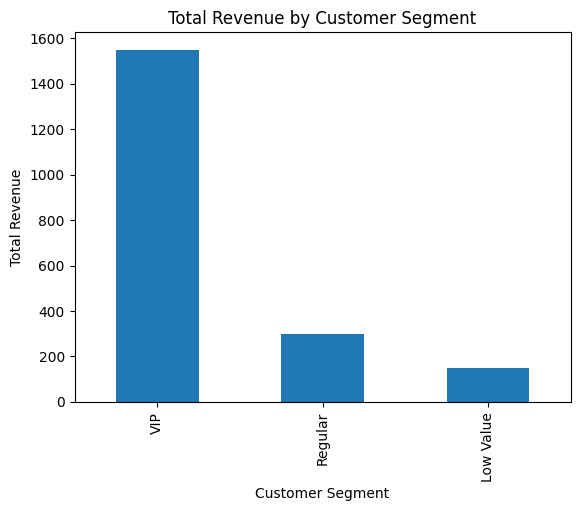

In [22]:
import matplotlib.pyplot as plt

segment_revenue = (
    df_customers
    .groupby("segment")["total_revenue"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure()
segment_revenue.plot(kind="bar")
plt.title("Total Revenue by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Total Revenue")
plt.show()


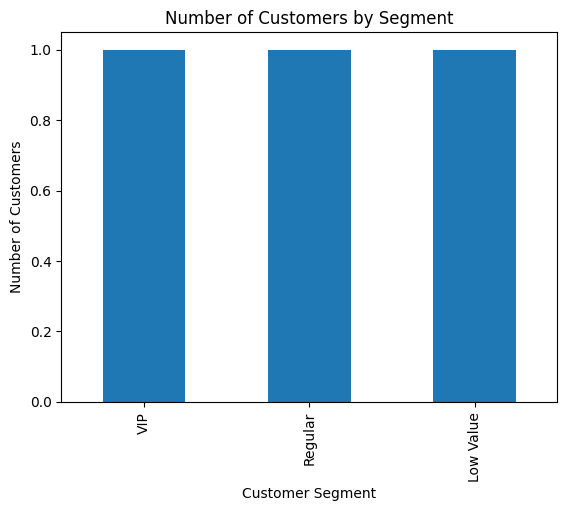

In [23]:
segment_counts = df_customers["segment"].value_counts()

plt.figure()
segment_counts.plot(kind="bar")
plt.title("Number of Customers by Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.show()


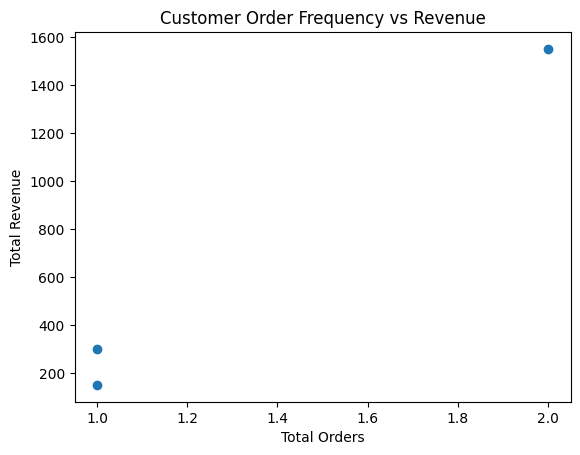

In [24]:
plt.figure()
plt.scatter(
    df_customers["total_orders"],
    df_customers["total_revenue"]
)
plt.xlabel("Total Orders")
plt.ylabel("Total Revenue")
plt.title("Customer Order Frequency vs Revenue")
plt.show()


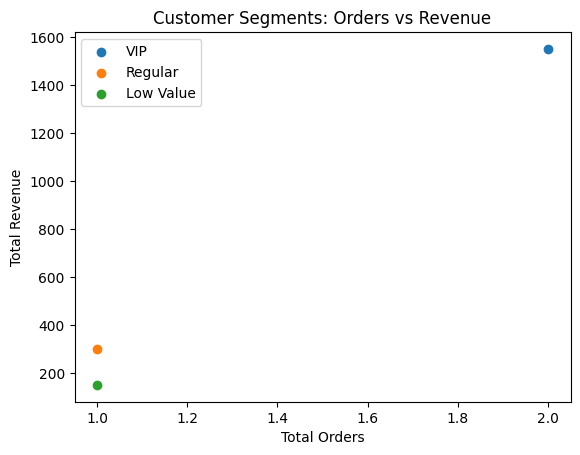

In [25]:
plt.figure()
for segment in df_customers["segment"].unique():
    subset = df_customers[df_customers["segment"] == segment]
    plt.scatter(
        subset["total_orders"],
        subset["total_revenue"],
        label=segment
    )

plt.xlabel("Total Orders")
plt.ylabel("Total Revenue")
plt.title("Customer Segments: Orders vs Revenue")
plt.legend()
plt.show()
